In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_DIR = '../../datasets/'

df = pd.read_csv(f'{DATA_DIR}tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'gender'])
df.sample(5)

,text,gender,tokenized
159100,BLOGGING ZE OSCARS (PART III) Lord of the Ring...,male,blogging ze oscars ( part iii ) lord of the ri...
290189,I got a new job yesterday. This one is suppose...,male,i got a new job yesterday . this one is suppos...
560793,"In Bihar, even horses have castes ' We decide...",male,"in bihar , even horses have castes ' we deci..."
161602,*** When XX gave me a ride across the bridge I...,female,* * * when xx gave me a ride across the bridge...
303672,"Well, it's been a long time since I've bothere...",female,"well , it 's been a long time since i 've both..."


In [3]:
df['gender'].value_counts(dropna=False)

male      322357
female    313242
Name: gender, dtype: int64

In [4]:
df_ = df.copy()
df_ = df_.dropna()
print(df_.shape)

(635599, 3)


In [5]:
enc = LabelEncoder()
enc.fit(df_['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['gender'] = enc.transform(df_['gender'])
encoded_labels

{'female': 0, 'male': 1}

In [6]:
X = df_['text']
y = df_['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((508479,), (127120,), (508479,), (127120,))

In [7]:
vect = TfidfVectorizer()
svm = LinearSVC()

pipe = make_pipeline(vect, svm)

In [8]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'linearsvc__random_state': [97],
}

In [9]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'linearsvc__random_state': 97, 'tfidfvectorizer__ngram_range': (1, 1)}


In [10]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     62503
           1       0.73      0.74      0.74     64617

    accuracy                           0.73    127120
   macro avg       0.73      0.73      0.73    127120
weighted avg       0.73      0.73      0.73    127120



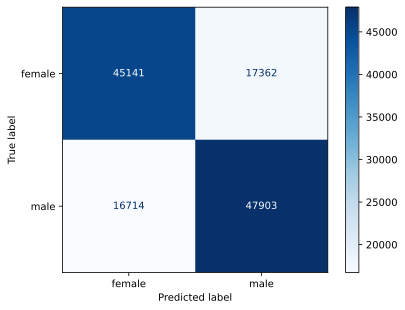

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [12]:
import joblib

joblib.dump(gs, 'gender_baseline.joblib')

['gender_baseline.joblib']

## Test the model

In [14]:
model = joblib.load('gender_baseline.joblib')

def predict_gender(text):
    classes = encoded_labels
    classes = {v: k for k, v in classes.items()} # reverse the dict
    return classes[model.predict([text])[0]]

In [15]:
predict_gender("Thanks to the best teams ever for making it possible!") # Male -> Correct

'male'

In [16]:
predict_gender("First time I got involved in a challenge was on 31-12-16 I took me almost 3 years, but I completed all the challenges") # Female -> Wrong

'male'

In [19]:
predict_gender("GM, and have a beautiful week everyone!") # Female -> Correct

'female'

In [20]:
predict_gender("I welcome the opportunity to meet the EU fishing sector in person and answer their questions about our EU Implementing Act on vulnerable marine ecosystems today.") # Male -> Correct

'male'

## Add *n*-gram features

In [7]:
from tempfile import mkdtemp
from shutil import rmtree

In [8]:
cache_dir = mkdtemp()

pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', LinearSVC(random_state=97))
    ],
    memory=cache_dir
)

In [11]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__analyzer': ['word', 'char'],
}

In [12]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\pipeline.py:336: UserWarning: Persisting input arguments took 302.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'clf__random_state': 97, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 3)}


In [13]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     62503
           1       0.74      0.74      0.74     64617

    accuracy                           0.74    127120
   macro avg       0.74      0.74      0.74    127120
weighted avg       0.74      0.74      0.74    127120



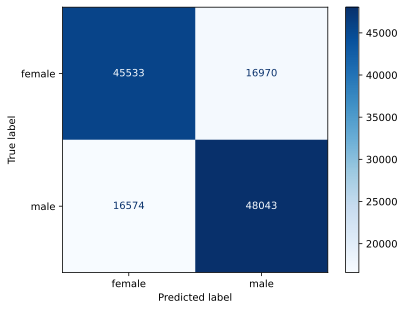

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [15]:
import joblib

joblib.dump(gs, 'gender_ngram.joblib')

['gender_ngram.joblib']

In [16]:
rmtree(cache_dir)

### Add PoS and punctuation features

In [2]:
DATA_DIR = '../../datasets/tokenized'

df = pd.read_csv(f'{DATA_DIR}/blog_authorship_tokenized_pos_punct_final.csv')
df.sample(5)

,text,gender,horoscope,job,age_group,tokenized,pos,total_punct,punct_dist,count_punct
407373,"Okay, so you know female cosmetic magazines? H...",male,Leo,Chemicals,18-24,"okay , so you know female cosmetic magazines ?...",INTJ PUNCT ADV PRON VERB ADJ ADJ NOUN PUNCT AU...,41,0.041165,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
202782,today my boss brought a magnet into my cube......,female,Leo,indUnk,25-34,today my boss brought a magnet into my cube .....,NOUN PRON NOUN VERB DET NOUN ADP PRON NOUN PUN...,15,0.058366,"{'!': 1, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
322947,... trying to put it into words myself when th...,female,Scorpio,indUnk,>35,... trying to put it into words myself when th...,PUNCT VERB PART VERB PRON ADP NOUN PRON SCONJ ...,4,0.055556,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
243715,I came across an article by Orson Scott Card e...,female,Aries,indUnk,25-34,i came across an article by orson scott card e...,PRON VERB ADP DET NOUN ADP PROPN PROPN PROPN V...,22,0.018503,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
622490,"Well, my eyes are red, my head is pounding, an...",female,Scorpio,Religion,18-24,"well , my eyes are red , my head is pounding ,...",INTJ PUNCT PRON NOUN AUX ADJ PUNCT PRON NOUN A...,42,0.071550,"{'!': 3, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."


In [3]:
df_ = df.drop(['horoscope', 'job', 'age_group', 'tokenized'], axis=1).sample(100000)
df_.sample(5)

,text,gender,pos,total_punct,punct_dist,count_punct
414565,"Howdy everybody, I have finally got my photos ...",male,INTJ PRON PUNCT PRON AUX ADV VERB PRON NOUN AD...,111,0.048094,"{'!': 6, '""': 4, '#': 0, '$': 0, '%': 0, '&': ..."
33252,I haven't updated in awhile. Who cares? Well t...,male,PRON AUX PART VERB ADP ADV PUNCT PRON VERB PUN...,1890,0.027779,"{'!': 28, '""': 2, '#': 0, '$': 0, '%': 0, '&':..."
285746,Why is it that we don't know what we want? Mos...,male,SCONJ AUX PRON SCONJ PRON AUX PART VERB PRON P...,7,0.044304,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
578673,"Art. As some of you may or may not know, of th...",male,NOUN PUNCT ADP DET ADP PRON AUX CCONJ AUX PART...,103,0.035456,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
383331,All of them are different. Start from the fir...,male,SPACE DET ADP PRON AUX ADJ PUNCT VERB ADP DET ...,15,0.027675,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."


In [4]:
df_['gender'].value_counts(dropna=False)

male      50677
female    49323
Name: gender, dtype: int64

In [5]:
enc = LabelEncoder()
enc.fit(df_['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['gender'] = enc.transform(df_['gender'])
encoded_labels

{'female': 0, 'male': 1}

In [6]:
X = df_.drop('gender', axis=1)
y = df_['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 5), (20000, 5), (80000,), (20000,))

In [7]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class RowIterator(TransformerMixin):
    """ Prepare Series for DictVectorizer """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from ast import literal_eval
        return X.apply(literal_eval)

In [8]:
from sklearn.pipeline import make_pipeline

word_pipe = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])
   
num_pipe = Pipeline([
    ('selector', ItemSelector(key=['total_punct', 'punct_dist']))
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight='balanced'))
])

In [10]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [10**x for x in range(-3, 3)],
}

In [11]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)
 
gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'clf__C': 0.1, 'feats__pos__vect__ngram_range': (1, 2), 'feats__word__vect__ngram_range': (1, 2)}


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      9909
           1       0.69      0.65      0.67     10091

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



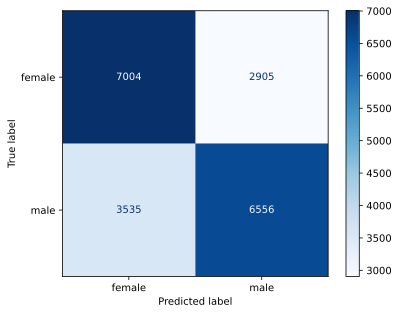

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [14]:
import joblib

joblib.dump(gs, 'gender_punct.joblib')

['gender_punct.joblib']

In [15]:
# from tempfile import mkdtemp
# from shutil import rmtree

# cache_dir = mkdtemp()
# rmtree(cache_dir)

## LIWC features

In [16]:
from __future__ import division
from __future__ import print_function

import re

from codecs import open
from collections import Counter


class DictFeaturizer(object):
    def __init__(self, dictionary, relative=True):
        self.dict = {}
        self.rel = relative
        matcher = re.compile(r'([\*\+])')

        for key, words in dictionary.items():

            normal = {x for x in words if not matcher.findall(x)}
            regexstring = "|".join([matcher.sub(r'\\w\1', x)
                                    for x in words if x not in normal])

            if regexstring:
                wildcards = re.compile(regexstring)
            else:
                wildcards = None

            self.dict[key] = (normal, wildcards)

    def transform(self, tokens):
        # Make frequency dictionary of the text to diminish number
        # of runs in further for loop
        freq_dict = Counter(tokens)
        features = dict()

        for key, wordlists in self.dict.items():

            normal, wildcards = wordlists

            keys = set(freq_dict.keys())

            features[key] = sum([freq_dict[k] for k in normal & keys])
            if wildcards:
                features[key] += sum([freq_dict[k] for k in keys - normal
                                      if wildcards.match(k)])

        if self.rel:
            return {k: v / len(tokens) for k, v in features.items()}
        else:
            return features

    @staticmethod
    def load(path, relative=True):
        d = {}
        with open(path, "r", encoding='utf-8') as f:
            for line in f:
                line = line.lower().strip().split(",")
                key, words = line[0], set(line[1:])
                d[key] = words

        return DictFeaturizer(d, relative=relative)


In [55]:
liwc = DictFeaturizer.load("../../datasets/LIWC/LIWC_English.csv")
sample_df = df.sample(100000)

In [57]:
sample_df = sample_df.assign(liwc=sample_df['tokenized'].apply(liwc.transform))
sample_df

,text,gender,horoscope,job,age_group,tokenized,pos,total_punct,punct_dist,count_punct,liwc
595703,"Yeah, but I may not be able to go. Still sick,...",male,Gemini,Non-Profit,<18,"yeah , but i may not be able to go . still sic...",INTJ PUNCT CCONJ PRON AUX PART AUX ADJ PART VE...,78,0.047532,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11382113821138211, 'pronoun': 0.06..."
592629,If only this would work on APDA speaking of w...,male,Gemini,Law,18-24,if only this would work on apda speaking of ...,SPACE SCONJ ADV DET AUX VERB ADP PROPN VERB AD...,45,0.037007,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11787974683544304, 'pronoun': 0.04..."
61908,"Hello? (HELLO, Hello, hello) Echo! (ECHO, Echo...",male,Cancer,Religion,<18,"hello ? ( hello , hello , hello ) echo ! ( ech...",INTJ PUNCT PUNCT INTJ PUNCT INTJ PUNCT INTJ PU...,25,0.060680,"{'!': 1, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.09655172413793103, 'pronoun': 0.05..."
271938,Elizabeth: Oh he is fine. He'll get over it. I...,female,Cancer,Student,<18,elizabeth : oh he is fine . he 'll get over it...,PROPN PUNCT INTJ PRON AUX ADJ PUNCT PRON AUX V...,23,0.060847,"{'!': 2, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.13466334164588528, 'pronoun': 0.05..."
5376,And Dan made me post the second game scores up...,female,Leo,Student,18-24,and dan made me post the second game scores up...,CCONJ PROPN VERB PRON VERB DET ADJ NOUN NOUN A...,13,0.064039,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.12206572769953052, 'pronoun': 0.04..."
...,...,...,...,...,...,...,...,...,...,...,...
301870,Yesterday in gym i hurt my legs. And today in ...,female,Scorpio,indUnk,<18,yesterday in gym i hurt my legs . and today in...,NOUN ADP NOUN PRON VERB PRON NOUN PUNCT CCONJ ...,9,0.017208,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11842105263157894, 'pronoun': 0.05..."
27393,Sometimes just sitting with people in silence ...,female,Gemini,indUnk,<18,sometimes just sitting with people in silence ...,ADV ADV VERB ADP NOUN ADP NOUN AUX AUX ADV ADJ...,77,0.052097,"{'!': 1, '""': 4, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.11573472041612484, 'pronoun': 0.05..."
65433,aggrivation. i have a tendency to write about ...,female,Gemini,indUnk,25-34,aggrivation . i have a tendency to write about...,NOUN PUNCT PRON AUX DET NOUN PART VERB ADP NOU...,129,0.034236,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.12023686920700309, 'pronoun': 0.05..."
94433,Is anyone else on blogger having as challengin...,female,Aquarius,indUnk,>35,is anyone else on blogger having as challengin...,AUX PRON ADV ADP NOUN VERB ADV VERB DET NOUN A...,16,0.028933,"{'!': 1, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...","{'funct': 0.13580246913580246, 'pronoun': 0.06..."


In [58]:
liwc_df = sample_df['liwc'].apply(pd.Series).fillna(0).add_prefix('liwc_')
sample_df = pd.concat([sample_df, liwc_df], axis=1).drop(['text', 'liwc'], axis=1)
sample_df.shape

(100000, 73)

In [59]:
sample_df['gender'].value_counts()

male      50640
female    49360
Name: gender, dtype: int64

In [60]:
enc = LabelEncoder()
enc.fit(sample_df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
sample_df['gender'] = enc.transform(sample_df['gender'])
encoded_labels

{'female': 0, 'male': 1}

In [61]:
X = sample_df.drop('gender', axis=1)
y = sample_df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 72), (20000, 72), (80000,), (20000,))

In [62]:
word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

num_cols = ['total_punct', 'punct_dist'] + [col for col in X.columns if col.startswith('liwc_')]

num_pipe = Pipeline([
    ('selector', ItemSelector(key=num_cols)),
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([(
        'feats', 
        FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight='balanced'))
])

In [63]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [10**x for x in range(-3, 3)],
}

In [64]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'clf__C': 0.1, 'feats__pos__vect__ngram_range': (1, 2), 'feats__word__vect__ngram_range': (1, 2)}


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [65]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      9868
           1       0.72      0.58      0.64     10132

    accuracy                           0.67     20000
   macro avg       0.68      0.67      0.67     20000
weighted avg       0.68      0.67      0.67     20000



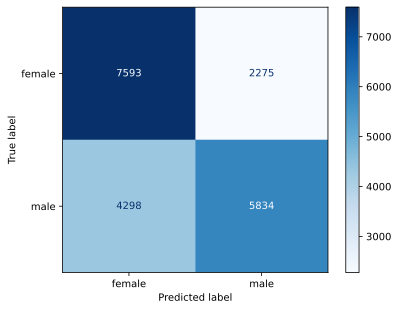

In [66]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [67]:
joblib.dump(gs, 'gender_liwc.joblib')

['gender_liwc.joblib']